# MLcourseProject - Deep Learning Your Brain
## Classification of Movement Execution and Imagination using EEG Signals
This repository is for the Advanced Topics in ML project Spring Semester 2019.

# Group members: 
Tim Fischer, Özhan Özen, Joaquin Penalver-Andres

# Project Description:
The project will focus on classification of movement imagination and movement tasks using EEG signals.

It has been proven that the mental planning or execution of different movements, produces different neuronal fooprints. These footprints can be detected by means of an EEG recording device. The goal of this project is to classify different movements that subjects may think of or execute. 

# DataSet
We will base our project on an existing dataset (link: https://www.physionet.org/physiobank/database/eegmmidb/#experimental-protocol ). 

The physionet dataset contains the following classes, with 109 subjects and 64 EGG Channels (Subjects 88, 92 and 100 have overlapping events. Please exclude these subjects).

LABELS	|	DESCRIPTION
------------------------------
0 	|	Baseline, eyes open           
1 	|	Baseline, eyes closed         
2 	|	Motor execution: Left Hand           
3 	|	Motor execution: Right Hand          
4 	|	Motor imagery: Left Hand           
5 	|	Motor imagery: Right Hand          
6 	|	Motor execution: Both Hands          
7 	|	Motor execution: Both Feet           
8 	|	Motor Im: Both Hands          
9 	|	Motor imagery: Both Feet           

We have chosen to include 8 classes (baselines are excluded) for classification. 

# Tools Used

- Pytorch (For NN training)
- MNE python (For downloading/loading eeg data and creating epochs)
- Tensorflow (for tensorboard visualization)
- Many other basic python modules for data processing
- The final test were done on a Ubuntu with two GPU


### Tensorboard
------------
To run the TensorBoard, open a new terminal, go to the ProjectCode folder and run the command `$ tensorboard --logdir=./logs --port=6006`. Then, open http://localhost:6006/ on your web browser. If you have logs in your log dir, you will see nice graphs ;)

(logdir should point to the log directory of your created logs)

Logs can be created by calling write_logs_for_tensorboard() -> Feel free to modify, extend this function or add more tensorboard functions for further analysis of network performance.


# Examples, literature or code that we were inspired:

- https://martinos.org/mne/stable/auto_examples/decoding/plot_decoding_csp_eeg.html#sphx-glr-auto-examples-decoding-plot-decoding-csp-eeg-py

# The preprocessing and Networks Trained:

### Pre-processing

- The epochs are taken to cover 2s on movement (trigger) offset with 160 samples per second. 
- Each epoch data are normalized to have zero mean and standard deviation of 1.
- Augmentation of data with gaussian noise and inpainting-like data removal for regularization are tried (both in time and channel axis), however, we could not detect significant difference.
- 20 subjects were included, with 8 classes (no baseline).
- Cropping the time axis in small windows (of 10 samples) was suggested in literature (Zhang,2018), we have followed the suggestion. Each network is trained with and without this technique.
- For 3D CNN, the 64 channels are mapped to their locations in the head as a 2D grid (11x10). In order to make this location information a rectangle, zeros are added where there is no electrode on the grid.
- Eventually the data shape were (nEpochs,nChannels,nSamples), (nEpochs,nChannelsX,nChannelsY,nSamples), (nEpochs*nWindows,nChannels,nSamples) or (nEpochs*nWindows,nChannelsX,nChannelsY,nSamples) depending on whether the time axis is cropped or not and whether it was 2D or 3D CNN.

### Networks Trained

1) 3D CNN
- Layer 1 -- (32x1x11x10x10--cropped) or (32x1x11x10x320--non_cropped) + ExpoRU (CELU) + BatchNorm
- Layer 2 -- (64x1x11x10x10--cropped) or (64x1x11x10x320--non_cropped) + ExpoRU (CELU) + BatchNorm
- Layer 3 -- (128x1x11x10x10--cropped) or (128x1x11x10x320--non_cropped) + ExpoRU (CELU) + BatchNorm
- Layer 4 -- (Flatten fully connected Linear, Droput=0.5) 

#### Note: All the kernel sizes were (3,3,3) with stride 1, and padding such that there were no reduction on the size.

2) 2D CNN 

- Layer 1 -- (32x1x64x10--cropped) or (32x1x64x320--non_cropped) + ExpoRU (CELU) + BatchNorm
- Layer 2 -- (64x1x64x10--cropped) or (64x1x64x320--non_cropped) + ExpoRU (CELU) + BatchNorm
- Layer 3 -- (128x1x64x10--cropped) or (128x1x64x320--non_cropped) + ExpoRU (CELU) + BatchNorm
- Layer 4 -- (Flatten fully connected Linear, Droput=0.5) 

#### Note: All the kernel sizes were (7,3) with stride 1, and padding such that there were no reduction on the size.

### For all the trainings, ADAM optimizer (lr:1e-3, weight decay:1e-4, scheduler with 20 steps and gamma 0.5), and Cross Entropy Loss (with sigmoid activation in the output) are used. Batch size was either 128 or 256.

# Results

The accuracy on the test sets for both CNNs with both cropped and non-cropped (of time axis) epochs are below. The in-class accuracy on the right is given for 3D-CNN cropped.

<img src="Results/Figures/Tables.png" alt="Drawing" style="width: 800px;">

As you see, cropping the time axis in time windows (of 10 samples) makes a huge difference

The training progress for accuracy and loss for cropped epochs are below.

<img src="Results/Figures/cropped.png" alt="Drawing" style="width: 1200px;">

The training progress for accuracy and loss for non-cropped epochs are below. You could see the huge overfitting.

<img src="Results/Figures/notcropped.png" alt="Drawing" style="width: 1200px;">



# Code: How-to
In order to run the project, you need to open the 'Main' jupyter notebook and run it from top to bottom.

All parameters necessary for adapting the classification can be modified inside the config/<myconfig.py> files.

To store specific settings, just add a class to myconfig.py, inheriting from DefaultConfig.

Put your configs which shall be evaluated inside the list_of_configs in the myconfig.py module.
	
Inside the main.py: Select your config via myList = myconfig.list_of_configs

In case of supplementary optimizers or nn, please add them to the optimizers.py or neural_nets package. Adapt the optimizer_list or nn_list (+nn_models_getter.py) the  in the defaultconifg.py respectively.

## Example config file to run any NN implemented/tested


#### Config class name to include in the list at the bottom.
class Config3DCNN_NOTCropped(DefaultConfig):
    verbose = 'CRITICAL'
    
    config_name = '3D CNN'
    config_remark = '3D CNN'
   
   #### Number of subjects.
    nSubj = 20 
    selected_subjects = selected_subjects[:nSubj]
    
   #### Selection of the network and optimizer, these names have to be in .py files.
    nn_list = ['ConvNet3D']  # Extend if you want more. Add them in the nn_models_getter.py module
    nn_selection_idx = 0
    optimizer_list = ['Adam']  # Extend if you want more. Add them in the optimizers.py module
    optimizer_selection_idx = 0  # Idx corresponds to entry optimizer_list (find below)
    learning_rate = 1e-3
    weight_decay = 1e-4
    
   #### Setting up a scheduler for learning rate.
    scheduler = True  
    schStepSize = 20
    schGamma = 0.5
    
   #### Number of epochs and early stopping settings.
    num_of_epochs = 50
    batch_size = 128
    use_early_stopping = True
    es_patience = num_of_epochs
    
   #### Normalization/augmentation settings
    normalize = True
    augment_with_gauss_noise = False
    augmentation_factor = 2
    augment_std_gauss = 0.2
    dropOut = False
    dropOutChOnly = False
    dropOutTimeOnly = False
    dropOutTilePerc = 0.5
    dropOutTimeTile = 40
    dropOutChannelTile = 8
    
   #### Epoch Settings
    time_before_event_s = 0.0  # Epochsize parameter: Start time before event.
    time_after_event_s = 2.0  # Epochsize parameter: Time after event.
    downSample = 1
    
   #### To make number of data points dividable with 10
    show_events_distribution = False
    removeLastData = True
    
   #### To make channel dimension 2d, or cropping the time axis.
    Elec2D = True
    wSize = 10
    wCropped = False
    
    
#### All the classes in this list will be trained.
list_of_configs = [Config3DCNN_Cropped]

# START OF THE CODE BELOW
# START OF THE CODE BELOW
# START OF THE CODE BELOW

## Loading of Modules


In [1]:
%matplotlib inline
#%matplotlib widget
%load_ext autoreload
%autoreload 2


import numpy as np
from visualisations import eeg_sample_plot, events_distribution_plot, curve_name_gen
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from datasets import ChannelsVoltageDataset
from neural_nets.nn_models_getter import get_nn_model
from optimizers import get_optimizer
from utils_train import fit, test, plot_all_metrics, plot_val_metrics, final_test_acc
from configs import configs_ozhan, configs_tim, configs_joaquin, configs_final
from data_loader_creation import get_dataloader_objects
from classification_results import results_storer
from datetime import datetime
import torch
import matplotlib.pyplot as plt

## Selecting the configuration (configs_final is the final one)

In [2]:
""" USER: SELECT THE CONFIGURATION YOU NEED """
myList = configs_final.list_of_configs

## Trainining, plotting and saving the models





 3D-CNN-tAxisNOTCropped 
-------------------------

We are not on the cluster...

Data is being loaded using MNE...


100%|██████████| 4/4 [00:18<00:00,  4.73s/it]


3600 matching events found
No baseline correction applied
...data loading with MNE was finished. 

Dataset is being made 2D...
Data is now 2D.

Normalizing data...
...data was normalized.

320  time samples and  10  EEG channels for one epoch are taken.  Total epoch number is  3600  and there are  20  subjects included.
 There are in total  8  classes for classification.


Expected network layer output shapes:
Input: [1, 11, 10, 320]
Layer 1 Out: [32, 11, 10, 320]
Layer 2 Out: [64, 11, 10, 320]
Layer 3 Out: [128, 11, 10, 320]
Linear Layer Features: 4505600 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.001 

-> Epoch 1/50: train_loss: 138.2285, train_accuracy: 22.7366%, val_loss: 115.8578, val_accuracy: 19.7531%
-> Epoch 2/50: train_loss: 94.9764, train_accuracy: 34.8765%, val_loss: 106.6442, val_accuracy: 23.1481%
-> Epoch 3/50: train_loss: 67.0529, train_accuracy: 46.7421%, val_loss: 149.4417, val_accuracy: 24.6914%
-> Epoch 4/50: trai

100%|██████████| 4/4 [00:18<00:00,  4.68s/it]


3600 matching events found
No baseline correction applied
...data loading with MNE was finished. 

Normalizing data...
...data was normalized.

320  time samples and  64  EEG channels for one epoch are taken.  Total epoch number is  3600  and there are  20  subjects included.
 There are in total  8  classes for classification.


Expected network layer output shapes:
Input: [1, 64, 320]
Layer 1 Out: [32, 64, 320]
Layer 2 Out: [64, 64, 320]
Layer 3 Out: [128, 64, 320]
Linear Layer Features: 2621440 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.001 

-> Epoch 1/50: train_loss: 63.8631, train_accuracy: 20.4047%, val_loss: 66.8083, val_accuracy: 20.6790%
-> Epoch 2/50: train_loss: 49.6965, train_accuracy: 33.9163%, val_loss: 58.4162, val_accuracy: 30.8642%
-> Epoch 3/50: train_loss: 37.5068, train_accuracy: 47.0850%, val_loss: 67.7114, val_accuracy: 31.7901%
-> Epoch 4/50: train_loss: 25.4048, train_accuracy: 57.8189%, val_loss: 71.3693, val

100%|██████████| 4/4 [00:18<00:00,  4.71s/it]


3600 matching events found
No baseline correction applied
...data loading with MNE was finished. 

Dataset is being made 2D...
Data is now 2D.

Normalizing data...
...data was normalized.

Dataset is being cropped in time axis...
Dataset is cropped. From shape (3600, 10, 11, 320) to (226800, 10, 11, 10) 

10  time samples and  10  EEG channels for one epoch are taken.  Total epoch number is  226800  and there are  20  subjects included.
 There are in total  8  classes for classification.


Expected network layer output shapes:
Input: [1, 11, 10, 10]
Layer 1 Out: [32, 11, 10, 10]
Layer 2 Out: [64, 11, 10, 10]
Layer 3 Out: [128, 11, 10, 10]
Linear Layer Features: 140800 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.001 

-> Epoch 1/50: train_loss: 3.2221, train_accuracy: 19.5860%, val_loss: 2.1471, val_accuracy: 27.5769%
-> Epoch 2/50: train_loss: 2.1778, train_accuracy: 30.1130%, val_loss: 1.8519, val_accuracy: 36.1699%
-> Epoch 3/50: tr

100%|██████████| 4/4 [00:19<00:00,  4.77s/it]


3600 matching events found
No baseline correction applied
...data loading with MNE was finished. 

Normalizing data...
...data was normalized.

Dataset is being cropped in time axis...
Dataset is cropped. From shape (3600, 64, 320) to (226800, 64, 10) 

10  time samples and  64  EEG channels for one epoch are taken.  Total epoch number is  226800  and there are  20  subjects included.
 There are in total  8  classes for classification.


Expected network layer output shapes:
Input: [1, 64, 10]
Layer 1 Out: [32, 64, 10]
Layer 2 Out: [64, 64, 10]
Layer 3 Out: [128, 64, 10]
Linear Layer Features: 81920 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.001 

-> Epoch 1/50: train_loss: 2.6777, train_accuracy: 20.6839%, val_loss: 1.9307, val_accuracy: 29.1691%
-> Epoch 2/50: train_loss: 1.9287, train_accuracy: 33.4520%, val_loss: 1.7151, val_accuracy: 41.0543%
-> Epoch 3/50: train_loss: 1.5590, train_accuracy: 43.2273%, val_loss: 1.4225, val_accu

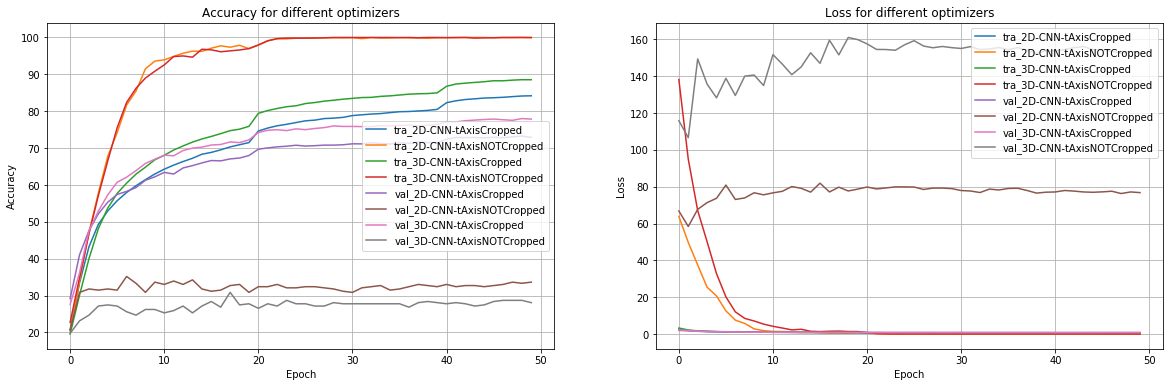

In [3]:
training_curves = {}

for my_cfg in myList:
    
    curve_name_gen(my_cfg)
    
    """ PREPARE DATALOADERS """
    train_dl, val_dl, test_dl, input_dimension_, output_dimension_ = get_dataloader_objects(my_cfg)

    
    """CLASSIFICATION"""
    # Get the model
    model_untrained = get_nn_model(my_cfg, input_dimension=input_dimension_,output_dimension=output_dimension_)

    # Get the optimizer
    optimizer = get_optimizer(my_cfg, model_untrained.parameters())

    # Train and show validation loss
    train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s =\
        fit(train_dl, val_dl, model_untrained, optimizer, my_cfg)
    
    curves = train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s
    training_curves[my_cfg.curve_name] = curves
    
    # Report final accuracy
    test_loss, test_accuracy =  final_test_acc(model_trained, test_dl, my_cfg)
    
    # Save the model
    todays_date = datetime.today().strftime('%Y%m%d_%H%M%S')
    todays_date = 'TrainedModel/'+todays_date
    todays_date_all = todays_date + '_all'
    torch.save(model_trained.state_dict(), todays_date)
    torch.save(model_trained, todays_date_all)

    # Store the results
    results_storer.store_results_for_plot(my_cfg,test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies)

    results_storer.store_results(my_cfg, model_trained, optimizer, test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies, test_dl)

"""Creates a figure with results and saves it"""
FigName = datetime.today().strftime('%Y%m%d_%H%M%S')
FigName = "Results/Figures/"+ FigName+".eps"
plot_all_metrics(training_curves)
plt.savefig(FigName, format='eps')

# The END